# Attacks on Number theoretic Assumptions

## Square Root Time Algorithms For Discrete Log
Suppose $G$ is a cyclic group of order $q$ generated by $g\in G$, $q$ may or may not be prime. Given $u \in G$, we hope to find an $\alpha \in Z_q$, such that $g^{\alpha} = u$     
Firstly, we try the simplest algorithm: **brute-force search**, try all $\beta = 1,2,3,...,q$ until we find the discrete log of $u$ 

In [233]:
from sage.all import *
import random

q = 17
a = random.randint(0, q-1)

#define a cyclic group G of order q
G = CyclicPermutationGroup(q)
#g is the generator of G
g = G.gen()
u = G(g**a)

print(f"actual a = {a}")

actual a = 6


In [234]:
import math

def brute_force_func(u, G, g, q):
    v = G(1)
    b = 0

    while v != u and b <= q:
        v = v * g
        b += 1
    return b

b = brute_force_func(u, G, g, q)
print(f"use brute force to get a' = {b}")

use brute force to get a' = 6


then we try a much faster algoritm: **baby step/giant step methon**   
Set $m:=\lceil q^{1/2} \rceil$, we can write the (unknown) discrete log $\alpha \in Z_q$ as $\alpha = \lambda ·m+\beta$, for some $0\leq \lambda,\beta < m$   
To find $\alpha$, it suffices to find $\beta$ and $\lambda$, that is:    
$$u = g^{\alpha} = g^{\lambda ·m+\beta} = (g^m)^{\lambda}·g^{\beta}$$    
we isolate $\beta$ and $\lambda$ to different sides of the equality:    
$$u·(g^{-m})^{\lambda}=g^{\beta}$$     
Now we can use the meet in the middle technology to find the pair of $\beta$ and $\lambda$

In [235]:
def baby_step_algo(u, G, g, q):
    # calculate m and g^{-m} mod q
    m = math.ceil(sqrt(q))
    g_invm = G(g**(-m))

    # initialize an empty array T
    T = {}
    v = G(1)
    for beta in range(0,m):
        T[v] = beta
        v = v * g
    
    # compute all the value of the left hand side and compare them one by one in Table_B
    v = u
    gamma = 0
    while v not in T:
        v = v * g_invm
        gamma += 1
    
    # once we have find a pair of (b,l), then we can confirm discrite log a
    beta = T[v]
    a = gamma * m + beta
    
    return a

b = baby_step_algo(u,G,g,q)
print(f"use baby step algorithm to get a' = {b}")

use baby step algorithm to get a' = 6


compare the efficiency of **baby step/giant step methon** with **brute-force methon**  
In theory, the running time of brute force is O(q), and 'Baby step' is O(q^(1/2))

## Discrete Log in Groups of Composite Order
In this section we look at algorithms for discrete log in a cyclic group $G$ of order $n$, where $n$ is composite.

### Groups of order $q^e$
Let $G$ be a cyclic group of order $q^e$ generated by $g$ in $G$, where $q$ > 1 (not necessarily prime) and
$e \geq 1$. Observe that for every $f = 0,...,e$   
$g_f := g^{(q^f)} \in G$ generates a subgroup of $G$ order $q^{(e−f)}$. In particular, $g_0 = g$ and $g_e = 1$, The element $g_{e−1}$ generates a subgroup of order $q$.    


In [236]:
from sage.all import *
import random

q = 17
e = 3
a = random.randint(0, q**e-1)

#define a cyclic group G of order q^e
G = CyclicPermutationGroup(q**e)
#find a random element in G as g
g = G.gen()
u = G(g**a)

# print(subgroup_generator(q, e, g, 1))
# print(G.list())
print(f"actual a = {a}")

actual a = 4150


In [237]:
def recursive_discrete_log(q, e, G, g, u):
    if e == 1:
        return baby_step_algo(u, G, g, q)
    else:
        f = int(round(e/2))
        b = recursive_discrete_log(q, f, G, subgroup_generator(q, G, g, e-f) , G(u**(q**(e-f))))
        l = recursive_discrete_log(q, e-f, G, subgroup_generator(q, G, g, f), u*((g**b)**(-1)))
        return (q**f)*l + b
    
#generate subg
def subgroup_generator(q, G, g, f):
    subg = G(g**(q**f))
#     subG = G.subgroup([subg])
#     new_order = q**(e-f)
#     print(f"subgroup of G\'s = {subG.order()}, in theory, its order should be {new_order}")
    return subg

a = recursive_discrete_log(q, e, G, g, u)
print(f"use RDL algorithm to get a' = {a}")

use RDL algorithm to get a' = 4150


### Groups of composite order: the Pohlig-Hellman algorithm

In [238]:
from sage.all import *
import random

# define the factorization n = (q1^e1)*(q2^e2)*...*(qr^er) 
# N = 4218
# n_factors = factor(N)
# n_factors_list = list(n_factors)

# # randomly choose a, 0<=a<n
# a_val = random.randint(0, N)

n = 275
n_factors = factor(n)
n_factors_list = list(n_factors)

a = random.randint(0, n)

#define a cyclic group G of order n
G = CyclicPermutationGroup(n)
#get G‘s generator g
g = G.gen()
u = G(g**a)

print(f"actual a = {a}")

actual a = 72


In [239]:
# Pohlig-Hellman algorithm
def pohlig_hellman_algo(n, n_factors_list, G, g, u):
    r = len(n_factors_list)
    a = []
    modules_qe = []
    
    for i in range(1, r+1):
        # get qi and ei
        q = n_factors_list[i-1][0]
        e = n_factors_list[i-1][1]
        # calculate modules qi^ei
        modules_qe.append(q**e)
        # calculate qi*, qi* = n/(qi^ei)
        q_star = int(n/(q**e))
        # ai ← RDL(qi, ei, g^qi∗ , u^qi∗)
        ai = recursive_discrete_log(q, e, G, G(g**q_star), G(u**q_star))
        a.append([ai])
        
    # a' ← CRT((a1, q1^e1),...,(ar, qr^er))
    final_a = CRT_vectors(a, modules_qe)
    return final_a[0]

pohlig_hellman_algo(n, n_factors_list, G, g, u)

72

compare the running time of PH algoritm with brute force:      
the difficulty of computing discrete logarithms in a cyclic group of order $n$ is determined by the size of $q_{max}$, the largest prime dividing $n$.

## Experiment Preparation Part

In [146]:
from sage.all import *
import random
#generate a list of groups with different q

#generate a list of groups with prime order
G_primes = []
for i in range(0,100):
    q = random_prime(5000,False,2)
    G = CyclicPermutationGroup(q)
    g = G.gen()
    G_primes.append((q,G,g))
G_primes.sort()

#generate a list of groups with composite order
G_composite = []
P = Primes()
while (len(G_composite)<300):
    composite = 1
    for i in range(10):
        exp = random.randint(0,3)
        composite = composite * P.unrank(i)** exp
    if composite < 10**5:
        q = composite
        G = CyclicPermutationGroup(q)
        g = G.gen()
        G_composite.append((q, G, g))
G_composite.sort()

### comparision in prime groups

fixed a =  2159


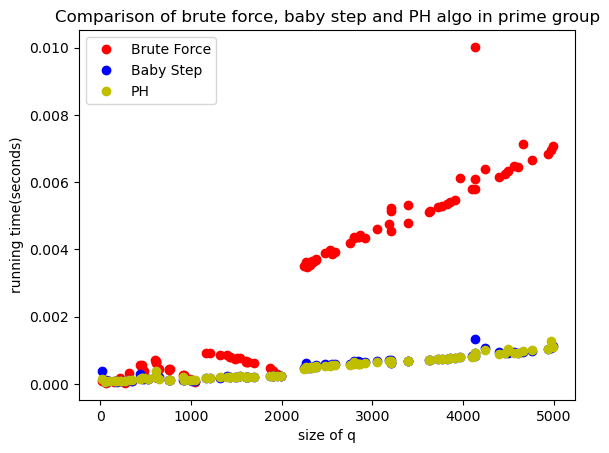

In [152]:
import random
import matplotlib.pyplot as plt
import time

# compare within the prime group

# generate a fixed a
fix_a = random.randint(0, 5000)
print('fixed a = ', fix_a)

time_of_brute_force = []
time_of_baby_step = []
time_of_PH = []
num_q = []
larget_primes_in_n = []

for (q,G,g) in G_primes:
    
    num_q.append(q)
    
    # calculate u = g^a
    a = fix_a % q
    u = G(g**a)
#     print(f"when q = {q}, actual_a = {a}")
    
    # calculate the time use in brute force
    t_start = time.time()
    dis_log_bf = brute_force_func(u,G,g,q)
    t_end = time.time()
    time_of_brute_force.append((t_end - t_start))
#     print(f"use brute force, get discrite log = {dis_log_bf}, brute force took {(t_end - t_start)} seconds")
    
    # calculate the time used in baby step algo
    t_start = time.time()
    dis_log_bs = baby_step_algo(u,G,g,q)
    t_end = time.time()
    time_of_baby_step.append((t_end - t_start))
#     print(f"use baby step, get discrite log = {dis_log_bs}, baby step took {(t_end - t_start)} seconds")
    
    # calculate the time used in PH algo
    n = q
    n_factors = factor(n)
    n_factors_list = list(n_factors)
    larget_primes_in_n.append(n_factors_list[-1][0])
    
    t_start = time.time()
    dis_log_PH = pohlig_hellman_algo(n, n_factors_list, G, g, u)
    t_end = time.time()
    time_of_PH.append((t_end - t_start))
#     print(f"use PH algo, get discrite log = {dis_log_PH}, baby step took {(t_end - t_start)} seconds")
    
    assert(dis_log_bf == a)
    assert(dis_log_bs == a)
    assert(dis_log_PH == a)
    
# draw a picture for comparison
l1 = plt.plot(num_q, time_of_brute_force, 'o',color = 'r', label = 'Brute Force')
l2 = plt.plot(num_q, time_of_baby_step, 'o',color = 'b', label = 'Baby Step')
l3 = plt.plot(num_q, time_of_PH, 'o',color = 'y', label = 'PH')
# plt.plot(nums, time_of_brute_force, 'ro', nums, time_of_baby_step, 'bo')
plt.title('Comparison of brute force, baby step and PH algo in prime group')
plt.xlabel('size of q')
plt.ylabel('running time(seconds)')
plt.legend()
plt.show()

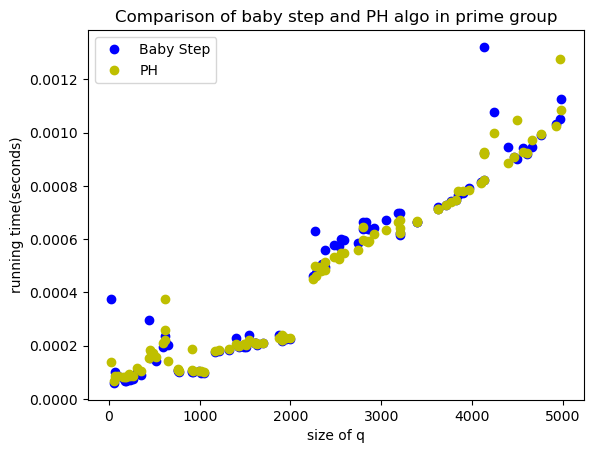

In [153]:
# only compare baby step and PH
l1 = plt.plot(num_q, time_of_baby_step, 'o',color = 'b', label = 'Baby Step')
l2 = plt.plot(num_q, time_of_PH, 'o',color = 'y', label = 'PH')
# plt.plot(nums, time_of_brute_force, 'ro', nums, time_of_baby_step, 'bo')
plt.title('Comparison of baby step and PH algo in prime group')
plt.xlabel('size of q')
plt.ylabel('running time(seconds)')
plt.legend()
plt.show()

### comparison in composite groups

fixed a =  52612


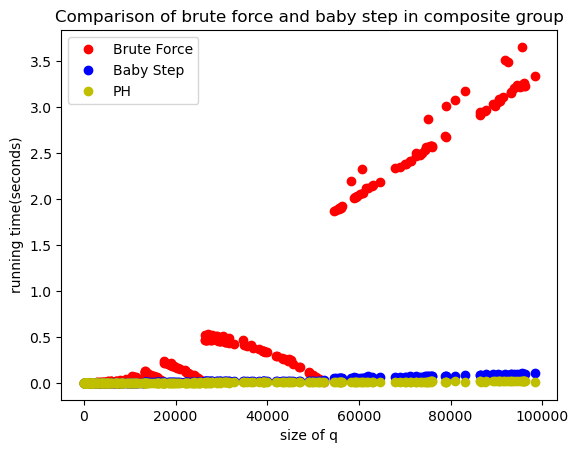

In [114]:
import random
import matplotlib.pyplot as plt
import time

# compare within the prime group

# generate a fixed a
fix_a = random.randint(0, 10**5)
print('fixed a = ', fix_a)

time_of_brute_force = []
time_of_baby_step = []
time_of_PH = []
num_q = []
larget_primes_in_n = []

for (q,G,g) in G_composite:
    
    num_q.append(q)
    
    # calculate u = g^a
    a = fix_a % q
    u = G(g**a)
#     print(f"when q = {q}, actual_a = {a}")
    
    # calculate the time use in brute force
    t_start = time.time()
    dis_log_bf = brute_force_func(u,G,g,q)
    t_end = time.time()
    time_of_brute_force.append((t_end - t_start))
#     print(f"use brute force, get discrite log = {dis_log_bf}, brute force took {(t_end - t_start)} seconds")
    
    # calculate the time used in baby step algo
    t_start = time.time()
    dis_log_bs = baby_step_algo(u,G,g,q)
    t_end = time.time()
    time_of_baby_step.append((t_end - t_start))
#     print(f"use baby step, get discrite log = {dis_log_bs}, baby step took {(t_end - t_start)} seconds")
    
    # calculate the time used in PH algo
    n = q
    n_factors = factor(n)
    n_factors_list = list(n_factors)
    
    t_start = time.time()
    dis_log_PH = pohlig_hellman_algo(n, n_factors_list, G, g, u)
    t_end = time.time()
    time_of_PH.append((t_end - t_start))
    # store (largest prime in n, 
    larget_primes_in_n.append((n_factors_list[-1][0],time_of_brute_force[-1],time_of_baby_step[-1],time_of_PH[-1]))
    
#     print(f"use PH algo, get discrite log = {dis_log_PH}, baby step took {(t_end - t_start)} seconds")
    
    assert(dis_log_bf == a)
    assert(dis_log_bs == a)
    assert(dis_log_PH == a)
    
# draw a picture for comparison
l1 = plt.plot(num_q, time_of_brute_force, 'o',color = 'r', label = 'Brute Force')
l2 = plt.plot(num_q, time_of_baby_step, 'o',color = 'b', label = 'Baby Step')
l3 = plt.plot(num_q, time_of_PH, 'o',color = 'y', label = 'PH')
# plt.plot(nums, time_of_brute_force, 'ro', nums, time_of_baby_step, 'bo')
plt.title('Comparison of brute force and baby step in composite group')
plt.xlabel('size of q')
plt.ylabel('running time(seconds)')
plt.legend()
plt.show()

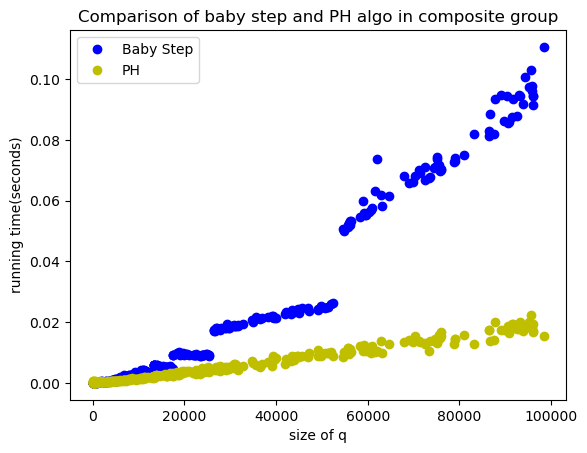

In [115]:
# only compare baby step and PH
l1 = plt.plot(num_q, time_of_baby_step, 'o',color = 'b', label = 'Baby Step')
l2 = plt.plot(num_q, time_of_PH, 'o',color = 'y', label = 'PH')
# plt.plot(nums, time_of_brute_force, 'ro', nums, time_of_baby_step, 'bo')
plt.title('Comparison of baby step and PH algo in composite group')
plt.xlabel('size of q')
plt.ylabel('running time(seconds)')
plt.legend()
plt.show()

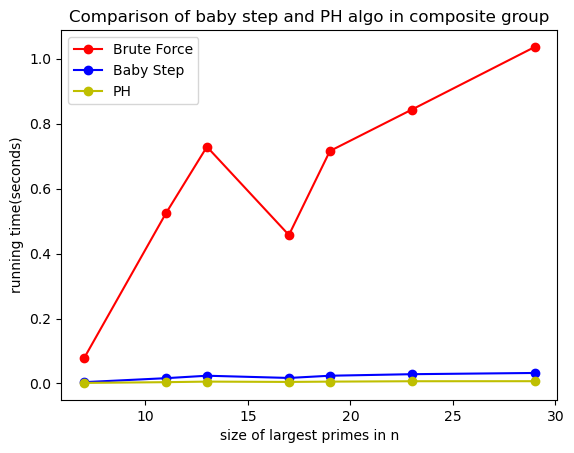

In [119]:
larget_primes_in_n.sort()

largest_primes = list(set(largest_prime))
largest_prime_bft = {}
largest_prime_bst = {}
largest_prime_pht = {}
for (p, bft, bst, pht) in larget_primes_in_n:
    if p not in largest_prime_bft:
        largest_prime_bft[p] = []
        largest_prime_bft[p].append(bft)
    else:
        largest_prime_bft[p].append(bft) 
        
    if p not in largest_prime_bst:
        largest_prime_bst[p] = []
        largest_prime_bst[p].append(bst)
    else:
        largest_prime_bst[p].append(bst)
    
    if p not in largest_prime_pht:
        largest_prime_pht[p] = []
        largest_prime_pht[p].append(pht)
    else:
        largest_prime_pht[p].append(pht)

largest_prime_bft_avg = []
largest_prime_bst_avg = []
largest_prime_pht_avg = []
for p in largest_primes:
    largest_prime_bft_avg.append(sum(largest_prime_bft[p])/len(largest_prime_bft[p]))
    largest_prime_bst_avg.append(sum(largest_prime_bst[p])/len(largest_prime_bst[p]))
    largest_prime_pht_avg.append(sum(largest_prime_pht[p])/len(largest_prime_pht[p]))

# only compare baby step and PH
l1 = plt.plot(largest_primes, largest_prime_bft_avg, 'o-',color = 'r', label = 'Brute Force')
l2 = plt.plot(largest_primes, largest_prime_bst_avg, 'o-',color = 'b', label = 'Baby Step')
l3 = plt.plot(largest_primes, largest_prime_pht_avg, 'o-',color = 'y', label = 'PH')
# plt.plot(nums, time_of_brute_force, 'ro', nums, time_of_baby_step, 'bo')
plt.title('Comparison of baby step and PH algo in composite group')
plt.xlabel('size of largest primes in n')
plt.ylabel('running time(seconds)')
plt.legend()
plt.show()

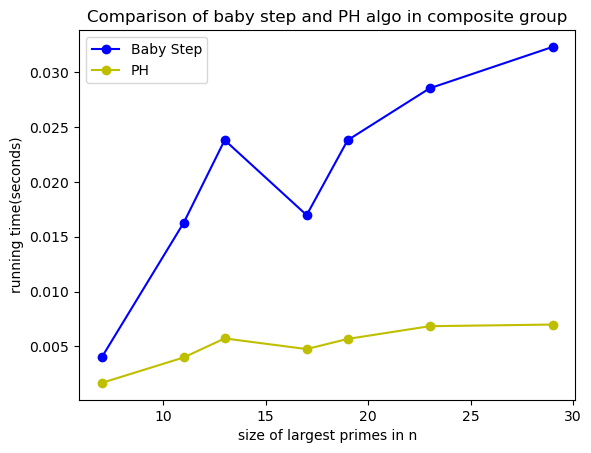

In [120]:
l1 = plt.plot(largest_primes, largest_prime_bst_avg, 'o-',color = 'b', label = 'Baby Step')
l2 = plt.plot(largest_primes, largest_prime_pht_avg, 'o-',color = 'y', label = 'PH')
# plt.plot(nums, time_of_brute_force, 'ro', nums, time_of_baby_step, 'bo')
plt.title('Comparison of baby step and PH algo in composite group')
plt.xlabel('size of largest primes in n')
plt.ylabel('running time(seconds)')
plt.legend()
plt.show()